# PRODUCT RATINGS PREDICTION USING the 'new_retail_data.csv' DATASET

**Business Context:**<br><br> One of the many potential business uses identified by the group for the chosen retail transactions dataset, is the possibility of predicting future product ratings for transaction based on the potential predictors included in the data. The code and analysis in this notebook explores this possibility.<br><br>
**Practical Business Applications of Ratings Predictions:**
- Personalized Product Recommendations: By predicting which products are likely to receive high ratings from a customer based on demographics and purchasing history.
- Stocking Popular Items and Phasing Out Unpopular Items: Allowing optimized inventory management.
- Promoting High-Rating Product and Discounting Low-Rating Products: For products expected to receive high/low ratings, respectively.
- Enhancing Loyalty Programs: By tailoring loyalty programs based on predicted ratings, offering rewards or incentives for purchases of highly-rated products.
- Maintaining Brand Reputation: By predicting and addressing potential low ratings, retailers can better manage their brand's reputation ensuring that customer feedback remains positive.<br><br>

**Predictive Models Rationale:**

- Two runs of predicting classification models were explored using Logistic Regression (Base Line), Random Forest Classifier, Gradient Boost Classifier and a Neural Network for each run.
    - The first run used the full cleaned data set after dropping NaNs and Variables that did not add to the explanation of ratings with 80% of rows as training set
    - The second run attempts to improve predictability of ratings by using a re-balanced training set applying SMOTE. This was done after noticing that results for the first run were being skewed by major overrepresentation of product transactions rated 4 in the scale of 1 to 5 present in the dataset.
- Detailed steps of each run are described beafore each section's code blocks.
- Hyperparameter Tunning: Due to computational capabilities limitations, hyperparameters for the different model were adjusted manually only in order to improve training speed. Grid Search tunning was attempted to improve prediction quality but was ultimately not implemented due to the extensive time required to train since no GPU was available.
- Neural Network Depth: for similar computational limitations the trained neural network for each run was limited to few layers.
- This modelling sequence allowed for comparisons between the predictive capabilities of each model.

**Conclusions:**

- Neither run yielded very robust models to accurately predict ratings using the features available in the dataset. 
- Testing accuracy did not surpass 36%. More sophisticated models and the neural networks did not perform better than the Logistic Regression baseline,
- Despite this, it is important to note that re-balancing the training set produced models that were much more succesful in producing True Positive classifications for all Ratings classes as they were not skewed by the imbalances present in the dataset favouring ratings of 4.
- Exploring this question allowed us to apply several concepts learned during the Scaling to Production, Algorithm and Data Structures and Deep Learning modules of the program. Most saliently, the computational limitations we experienced highlighted the importance of Algorithm efficiency and data structures when training machine learning models.

**Limitations, Improvement Opportunities and Future Development**

- **Find other datasets:** Datasets with more balanced product ratings labels as well as additional demographic and transactional features may yield better prediction results.
- **Comprehensive Hyperparameter Tunning**: A full Grid Search hyperparameter tunning that allows, among other things, for deeper trees in the Random Forest and Gradient Boosting Classifiers may also improve prediction capabilities. Computational limitations prevented such full tunning for this version of the project.
- **Deeper Neural Networks**: Computational power also hindered our ability to train more complex neural networks which could yield better predictions.
- **Subject Matter Expert Inputs**: Incorporating the input of subject matter experts and retailer stakeholders can better guide modeling and identify modeling improvements opporunities for product ratings predictions.


# 1. Ratings Prediction Training on Original Dataset - 20% Test Split

**STEPS:**<br><br>
1. Data Cleaning:

- Loaded the dataset and dropped rows with missing values in the Ratings column.
- Dropped irrelevant columns: Transaction_ID, Name, Email, Phone, Address, Date, Feedback, Zipcode, Year, Month, Time, City, and State.
- Dropped the Total_Amount column.
- Dropped rows with any other missing values.

2. Data Preprocessing:

- Identified numerical columns (Total_Purchases, Amount) and categorical columns.
- Defined a preprocessing pipeline using ColumnTransformer:
- Applied StandardScaler to numerical columns.
- Applied OneHotEncoder to categorical columns.

3. Model Pipelines:

- Created pipelines for three models: LogisticRegression, RandomForestClassifier, and GradientBoostingClassifier.
- Each pipeline includes the preprocessing step followed by the classifier.

4. Model Training and Testing:

- Split the data into training and test sets using stratified sampling.
- Trained each model on the training set and evaluated on the test set.
- Calculated classification metrics (precision, recall, f1-score) and confusion matrix for each model.

5. Results and Performance Summarization:

- For each model, plotted True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN) as a grouped bar chart in percentages.
- For RandomForest and GradientBoosting, plotted feature importance, showing the top 20 most important features.

6. Neural Network:

- Applied the same preprocessing pipeline to the training and test sets.
- Defined a simple neural network model with two hidden layers and a softmax output layer for multi-class classification.
- Trained the neural network on the unbalanced training set and evaluated it on the test set.
- Plotted the same metrics (TP, FP, TN, FN) as a grouped bar chart.

## 1A. Ratings Prediction Using Logistic Regression, Random Forest and XGBosst: UNBALANCED TRAINING SET

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import set_config

# Load the dataset
file_path = '../data/raw/new_retail_data.csv'
data = pd.read_csv(file_path)

In [2]:
#DATA CLEANING
# Drop rows with missing values in the 'Ratings' column
data = data.dropna(subset=['Ratings'])

# Drop irrelevant columns
data = data.drop(columns=['Transaction_ID', 'Name', 'Email', 'Phone', 'Address', 'Date', 'Feedback','Zipcode','Year','Month', 'Time','City','State'])

# Extract hour from Time column with specified format
#data['Hour'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.hour
#data = data.drop(columns=['Time'])

# Combine Country and Zipcode to create a unique zipcode feature
#data['Country_Zipcode'] = data['Country'].astype(str) + '_' + data['Zipcode'].astype(str)
#data = data.drop(columns=['Zipcode'])

# Drop rows with any other missing values
data = data.dropna()

# Remove Total_Amount column
data = data.drop(columns=['Total_Amount'])

In [3]:
#DATA PREPROCESSING AND MODEL PIPELINES
# Prepare the features and target from the full dataset
X = data.drop(columns=['Ratings'])
y = data['Ratings'].astype(int)

# Split the data into training and test sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Identify numerical and categorical columns
numerical_cols = ['Total_Purchases', 'Amount']
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define the models in the desired order
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(max_depth=5, random_state=42)
}

--- LogisticRegression Pipeline Structure ---


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Total_Purchases',
                                                   'Amount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Country', 'Gender',
                                                   'Income', 'Customer_Segment',
                                                   'Product_Category',
                                                   'Product_Brand',
                                                   'Product_Type',
                                                   'Shipping_Method',
                                                   'Payment_Method',
                                                   'Order_Status',
                                                   'products'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

--- LogisticRegression ---
Training and evaluation time: 4.95 seconds
              precision    recall  f1-score   support

           1       0.22      0.01      0.01      8549
           2       0.27      0.17      0.21     12361
           3       0.45      0.07      0.12      9405
           4       0.33      0.85      0.47     19346
           5       0.33      0.01      0.02      9894

    accuracy                           0.32     59555
   macro avg       0.32      0.22      0.17     59555
weighted avg       0.32      0.32      0.22     59555



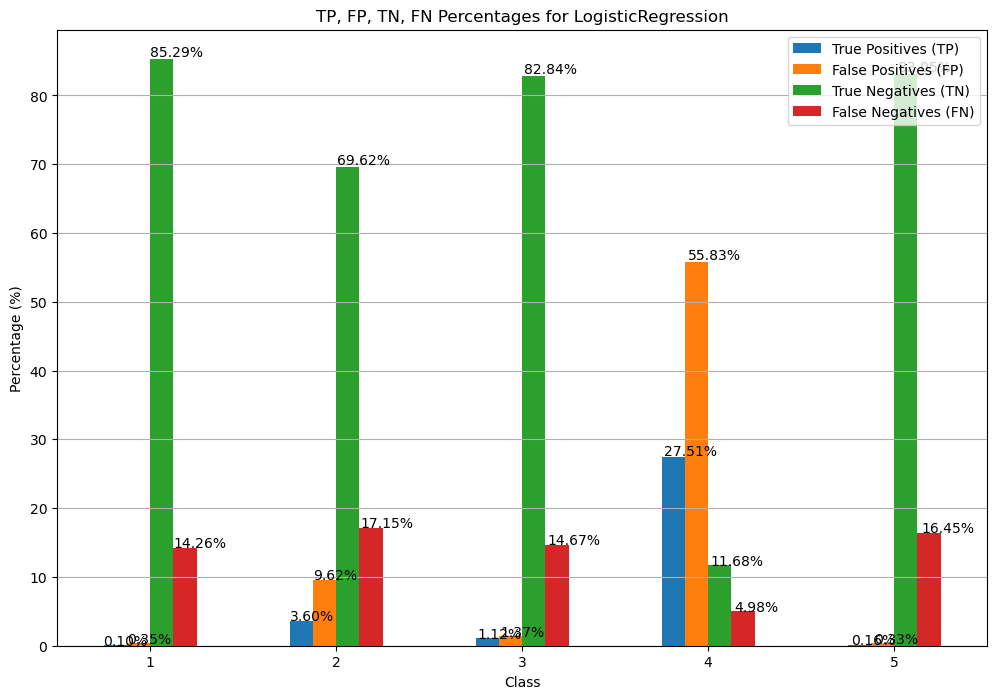

--- RandomForest Pipeline Structure ---


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Total_Purchases',
                                                   'Amount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Country', 'Gender',
                                                   'Income', 'Customer_Segment',
                                                   'Product_Category',
                                                   'Product_Brand',
                                                   'Product_Type',
                                                   'Shipping_Method',
                                                   'Payment_Method',
                                                   'Order_Status',
                                                   'products'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_jobs=-1,
                                        random_state=42))])

--- RandomForest ---
Training and evaluation time: 13.88 seconds
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      8549
           2       0.49      0.00      0.00     12361
           3       0.48      0.01      0.02      9405
           4       0.32      0.99      0.49     19346
           5       0.48      0.00      0.00      9894

    accuracy                           0.32     59555
   macro avg       0.36      0.20      0.10     59555
weighted avg       0.36      0.32      0.16     59555



c:\Users\pocho\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pocho\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pocho\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

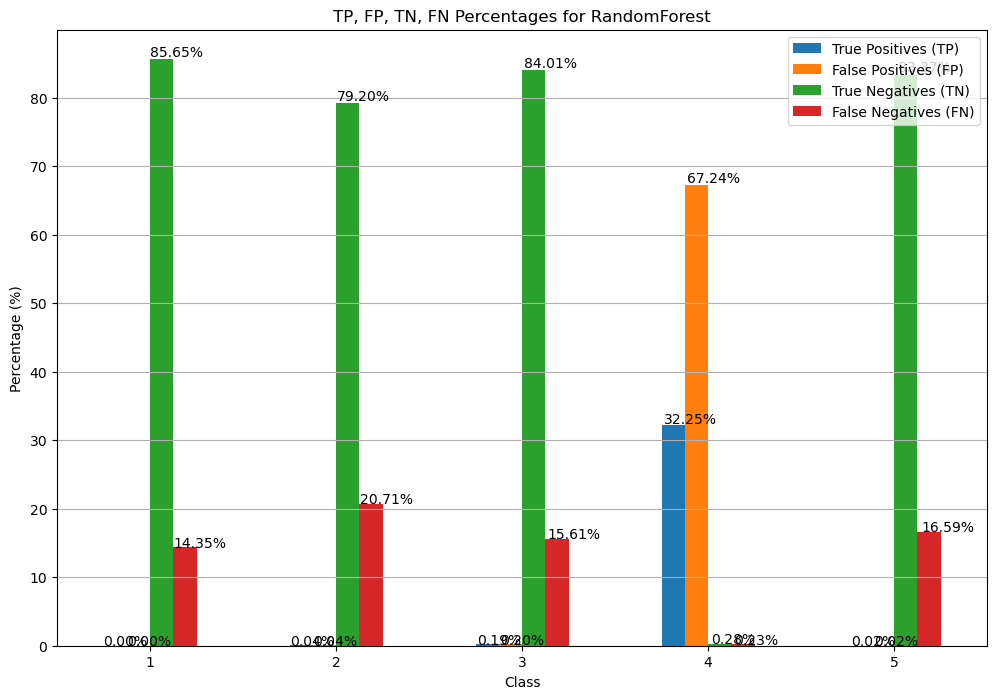

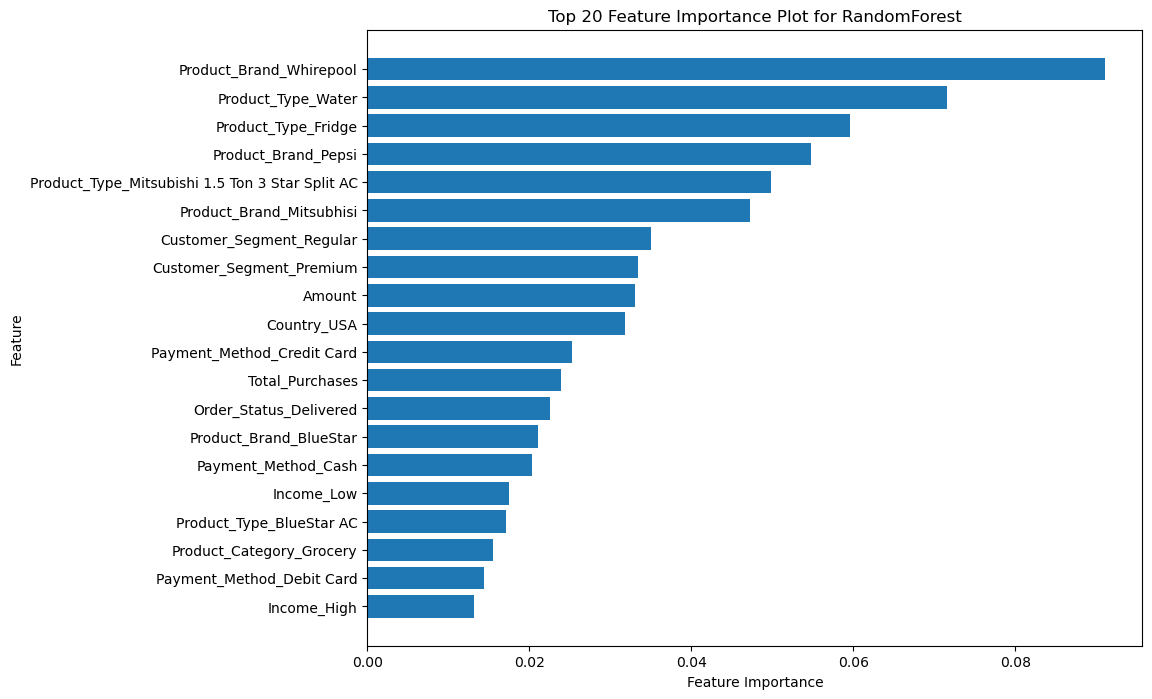

--- GradientBoosting Pipeline Structure ---


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Total_Purchases',
                                                   'Amount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Country', 'Gender',
                                                   'Income', 'Customer_Segment',
                                                   'Product_Category',
                                                   'Product_Brand',
                                                   'Product_Type',
                                                   'Shipping_Method',
                                                   'Payment_Method',
                                                   'Order_Status',
                                                   'products'])])),
                ('classifier',
                 GradientBoostingClassifier(max_depth=5, random_state=42))])

--- GradientBoosting ---
Training and evaluation time: 375.27 seconds
              precision    recall  f1-score   support

           1       0.26      0.01      0.01      8549
           2       0.33      0.13      0.19     12361
           3       0.48      0.11      0.18      9405
           4       0.33      0.88      0.48     19346
           5       0.39      0.01      0.02      9894

    accuracy                           0.33     59555
   macro avg       0.36      0.23      0.18     59555
weighted avg       0.35      0.33      0.23     59555



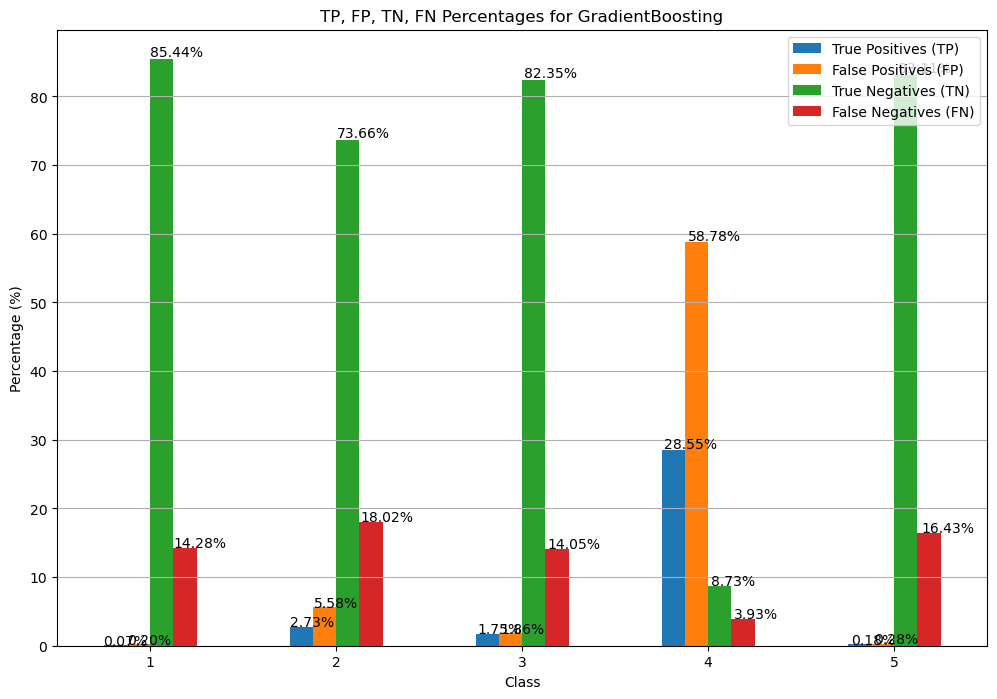

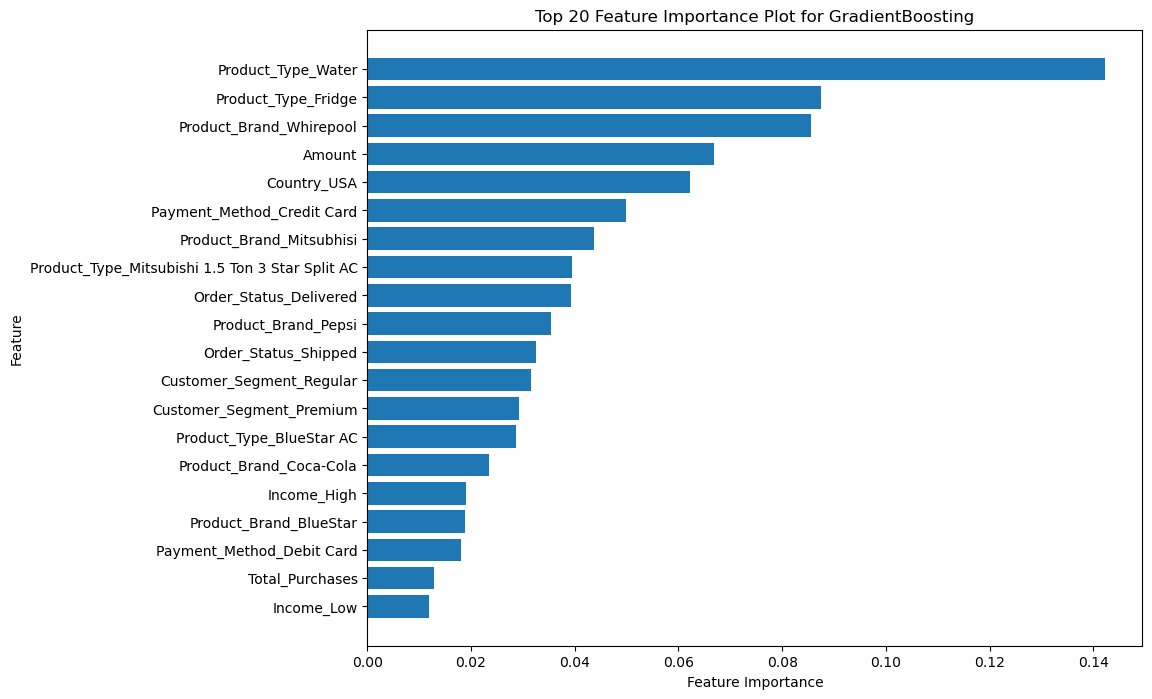

In [4]:
#MODEL TRAINING AND TESTING
# Visualize and train each model in the specified order
set_config(display='diagram')

for model_name, model in models.items():
    # Create a pipeline with preprocessing and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Display the pipeline structure
    print(f'--- {model_name} Pipeline Structure ---')
    display(pipeline)
    
    # Train and evaluate the model
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    elapsed_time = time.time() - start_time
    
    print(f'--- {model_name} ---')
    print(f'Training and evaluation time: {elapsed_time:.2f} seconds')
    print(classification_report(y_test, y_pred))
    
    # Create and calculate confusion matrix values
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_labels = sorted(y.unique())
    
    # Initialize lists to store the metrics for plotting
    tp_list, fp_list, tn_list, fn_list = [], [], [], []
    
    for i, class_label in enumerate(class_labels):
        TP = conf_matrix[i, i]
        FP = conf_matrix[:, i].sum() - TP
        FN = conf_matrix[i, :].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)
        
        # Calculate percentages
        total = TP + FP + FN + TN
        tp_list.append(TP / total * 100)
        fp_list.append(FP / total * 100)
        tn_list.append(TN / total * 100)
        fn_list.append(FN / total * 100)
    
    # Create a DataFrame for plotting
    metrics_df = pd.DataFrame({
        'Class': class_labels,
        'True Positives (TP)': tp_list,
        'False Positives (FP)': fp_list,
        'True Negatives (TN)': tn_list,
        'False Negatives (FN)': fn_list
    })
    
    # Plot the metrics as a grouped bar chart in percentages
    ax = metrics_df.set_index('Class').plot(kind='bar', figsize=(12, 8))
    plt.title(f'TP, FP, TN, FN Percentages for {model_name}')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Class')
    plt.xticks(rotation=0)
    plt.legend(loc='upper right')
    plt.grid(axis='y')

    # Annotate each bar with the percentage value
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() * 1.005, p.get_height() * 1.005))

    plt.show()

    # For feature importance plot only for RandomForest and GradientBoosting
    if model_name != 'LogisticRegression':
        importances = model.feature_importances_
        feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)  # Show only top 20 features
        
        plt.figure(figsize=(10, 8))
        plt.barh(importance_df['Feature'], importance_df['Importance'])
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.title(f'Top 20 Feature Importance Plot for {model_name}')
        plt.gca().invert_yaxis()
        plt.show()

## 1B. Prediction Using a Neural Network: UNBALANCED TRAINING SET

Epoch 1/20
5956/5956 - 13s - loss: 1.5154 - accuracy: 0.3241 - val_loss: 1.4860 - val_accuracy: 0.3292 - 13s/epoch - 2ms/step
Epoch 2/20
5956/5956 - 13s - loss: 1.4892 - accuracy: 0.3298 - val_loss: 1.4813 - val_accuracy: 0.3302 - 13s/epoch - 2ms/step
Epoch 3/20
5956/5956 - 12s - loss: 1.4853 - accuracy: 0.3316 - val_loss: 1.4799 - val_accuracy: 0.3304 - 12s/epoch - 2ms/step
Epoch 4/20
5956/5956 - 12s - loss: 1.4813 - accuracy: 0.3333 - val_loss: 1.4807 - val_accuracy: 0.3306 - 12s/epoch - 2ms/step
Epoch 5/20
5956/5956 - 12s - loss: 1.4800 - accuracy: 0.3335 - val_loss: 1.4810 - val_accuracy: 0.3308 - 12s/epoch - 2ms/step
Epoch 6/20
5956/5956 - 12s - loss: 1.4773 - accuracy: 0.3334 - val_loss: 1.4820 - val_accuracy: 0.3301 - 12s/epoch - 2ms/step
Epoch 7/20
5956/5956 - 12s - loss: 1.4752 - accuracy: 0.3338 - val_loss: 1.4825 - val_accuracy: 0.3322 - 12s/epoch - 2ms/step
Epoch 8/20
5956/5956 - 14s - loss: 1.4731 - accuracy: 0.3347 - val_loss: 1.4847 - val_accuracy: 0.3295 - 14s/epoch - 2

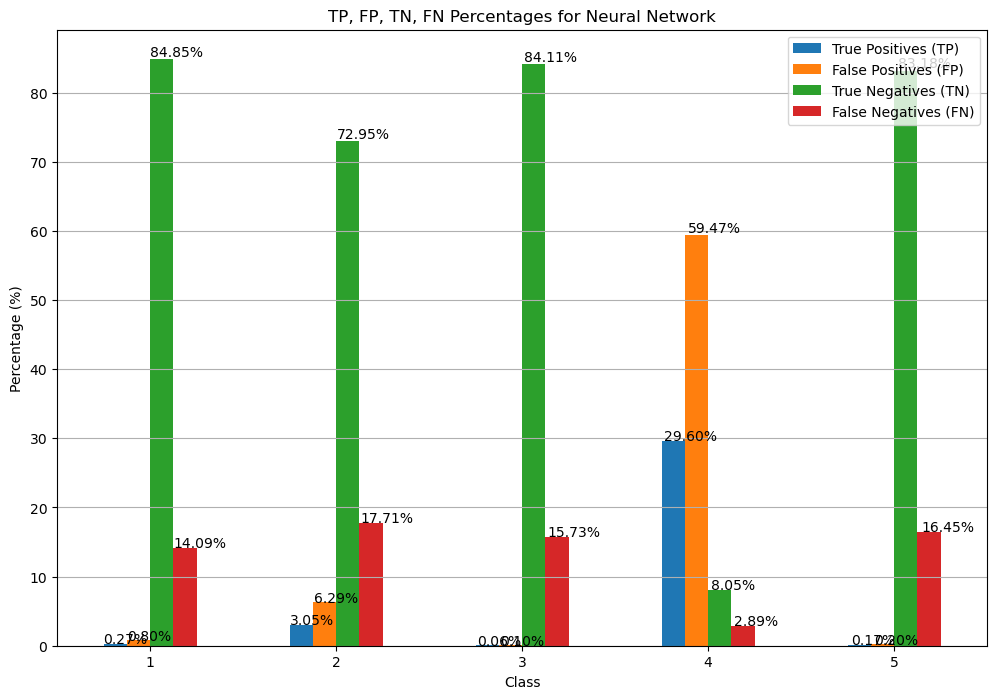

In [5]:
#NEURAL NETWORK PREDICTION
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Preprocess the data using the previously defined pipeline
X_train_transformed = preprocessor.fit_transform(X_train).toarray()
X_test_transformed = preprocessor.transform(X_test).toarray()

# One-hot encode the labels
y_train_nn = to_categorical(y_train)
y_test_nn = to_categorical(y_test)

# Define the neural network model
model = Sequential()

# Input layer
model.add(Dense(units=64, activation='relu', input_shape=(X_train_transformed.shape[1],)))

# Hidden layers
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer with softmax activation for multi-class classification
model.add(Dense(units=y_train_nn.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_transformed, y_train_nn, epochs=20, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_transformed, y_test_nn, verbose=2)

print(f'\nTest Accuracy: {test_accuracy:.2f}')

# Predict on the test set
y_pred_nn = model.predict(X_test_transformed)
y_pred_classes_nn = y_pred_nn.argmax(axis=-1)  # Convert predictions to class labels

# Classification report
print(classification_report(y_test, y_pred_classes_nn))

# Confusion matrix
conf_matrix_nn = confusion_matrix(y_test, y_pred_classes_nn)

# Plot confusion matrix and metrics
class_labels = sorted(y.unique())

# Initialize lists to store the metrics for plotting
tp_list, fp_list, tn_list, fn_list = [], [], [], []

for i, class_label in enumerate(class_labels):
    TP = conf_matrix_nn[i, i]
    FP = conf_matrix_nn[:, i].sum() - TP
    FN = conf_matrix_nn[i, :].sum() - TP
    TN = conf_matrix_nn.sum() - (TP + FP + FN)
    
    # Calculate percentages
    total = TP + FP + FN + TN
    tp_list.append(TP / total * 100)
    fp_list.append(FP / total * 100)
    tn_list.append(TN / total * 100)
    fn_list.append(FN / total * 100)

# Create a DataFrame for plotting
metrics_df_nn = pd.DataFrame({
    'Class': class_labels,
    'True Positives (TP)': tp_list,
    'False Positives (FP)': fp_list,
    'True Negatives (TN)': tn_list,
    'False Negatives (FN)': fn_list
})

# Plot the metrics as a grouped bar chart in percentages
ax = metrics_df_nn.set_index('Class').plot(kind='bar', figsize=(12, 8))
plt.title(f'TP, FP, TN, FN Percentages for Neural Network')
plt.ylabel('Percentage (%)')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.grid(axis='y')

# Annotate each bar with the percentage value
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

# 2. Ratings Prediction Training on Balanced Data Applying SMOTE

**STEPS:**<br><br>
1. Data Cleaning:

- Similar data cleaning steps as the unbalanced set, including dropping missing values, irrelevant columns, and Total_Amount.

2. Data Preprocessing:

- Identified numerical and categorical columns, similar to the unbalanced set.
- Applied the same preprocessing pipeline using StandardScaler for numerical columns and OneHotEncoder for categorical columns.

3. Balancing the Training Set with SMOTE:

- Applied SMOTE to the preprocessed training set to balance the classes in the Ratings target variable.
- Resampled the training set to ensure equal representation of all classes.

4. Model Pipelines:

- Similar pipelines for LogisticRegression, RandomForestClassifier, and GradientBoostingClassifier.
- Since preprocessing was applied before SMOTE, the models were trained on the balanced resampled data without additional preprocessing.

5. Model Training and Testing:

- Trained each model on the SMOTE-balanced training set and evaluated on the original test set.
- Calculated classification metrics (precision, recall, f1-score) and confusion matrix for each model.

6. Results and Performance Summarization:

- Similar to the unbalanced set, plotted TP, FP, TN, and FN as a grouped bar chart for each model.
- For RandomForest and GradientBoosting, plotted feature importance with the top 20 features.

7. Neural Network:

- Preprocessed the resampled training set and original test set.
- Trained the same neural network model on the balanced dataset.
- Evaluated the model and plotted TP, FP, TN, and FN as a grouped bar chart.

## 2A. Ratings Prediction Using Logistic Regression, Random Forest and XGBosst: BALANCED TRAINING SET

In [7]:
#!pip install imbalanced-learn

   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   ---------------------------------------  256.0/258.3 kB 7.9 MB/s eta 0:00:01
   ---------------------------------------- 258.3/258.3 kB 5.3 MB/s eta 0:00:00


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import set_config
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = '../data/raw/new_retail_data.csv'
data = pd.read_csv(file_path)

In [2]:
#DATA CLEANING
# Drop rows with missing values in the 'Ratings' column
data = data.dropna(subset=['Ratings'])

# Drop irrelevant columns
data = data.drop(columns=['Transaction_ID', 'Name', 'Email', 'Phone', 'Address', 'Date', 'Feedback','Zipcode','Year','Month', 'Time','City','State'])

# Drop rows with any other missing values
data = data.dropna()

# Remove Total_Amount column
data = data.drop(columns=['Total_Amount'])

In [4]:
#DATA PREPROCESSING AND MODEL PIPELINES
# Prepare the features and target from the full dataset
X = data.drop(columns=['Ratings'])
y = data['Ratings'].astype(int)

# Split the data into training and test sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Identify numerical and categorical columns
numerical_cols = ['Total_Purchases', 'Amount']
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Apply preprocessing to the training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# Define the models in the desired order
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(max_depth=5, random_state=42)
}

--- LogisticRegression ---
              precision    recall  f1-score   support

           1       0.20      0.43      0.27      8549
           2       0.25      0.23      0.24     12361
           3       0.30      0.34      0.32      9405
           4       0.35      0.07      0.12     19346
           5       0.22      0.33      0.27      9894

    accuracy                           0.24     59555
   macro avg       0.26      0.28      0.24     59555
weighted avg       0.28      0.24      0.22     59555



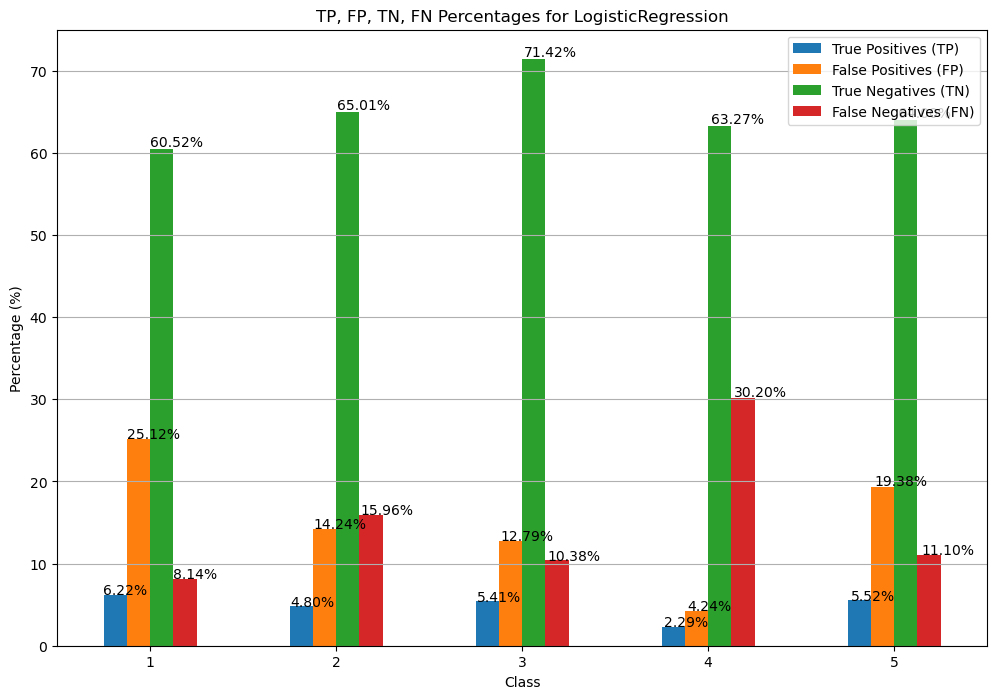

--- RandomForest ---
              precision    recall  f1-score   support

           1       0.21      0.44      0.28      8549
           2       0.27      0.26      0.27     12361
           3       0.40      0.27      0.32      9405
           4       0.35      0.26      0.30     19346
           5       0.25      0.21      0.23      9894

    accuracy                           0.28     59555
   macro avg       0.29      0.29      0.28     59555
weighted avg       0.30      0.28      0.28     59555



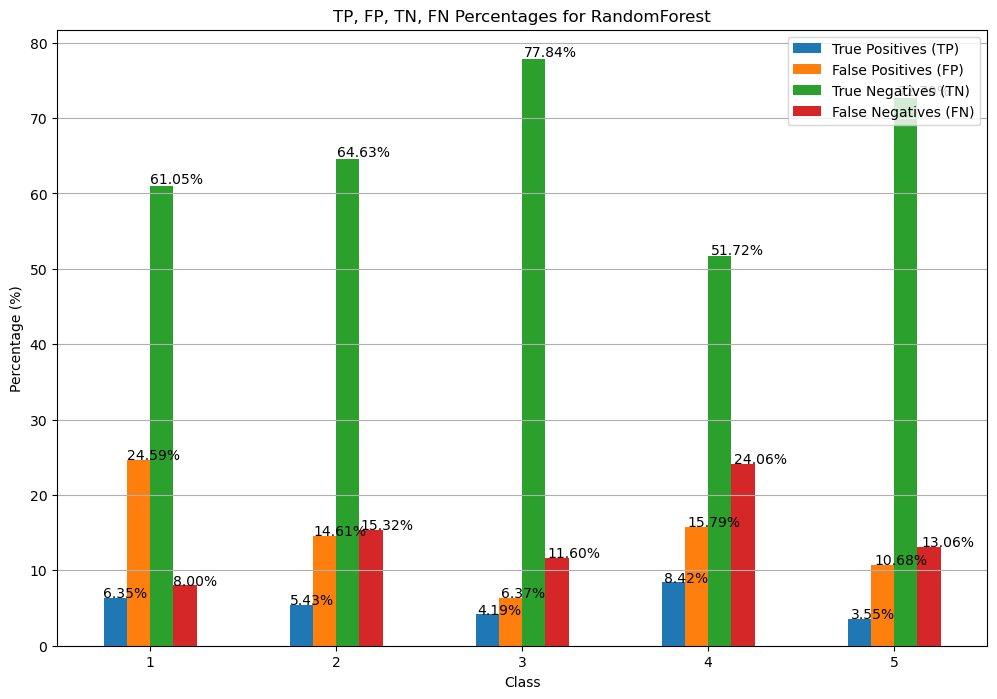

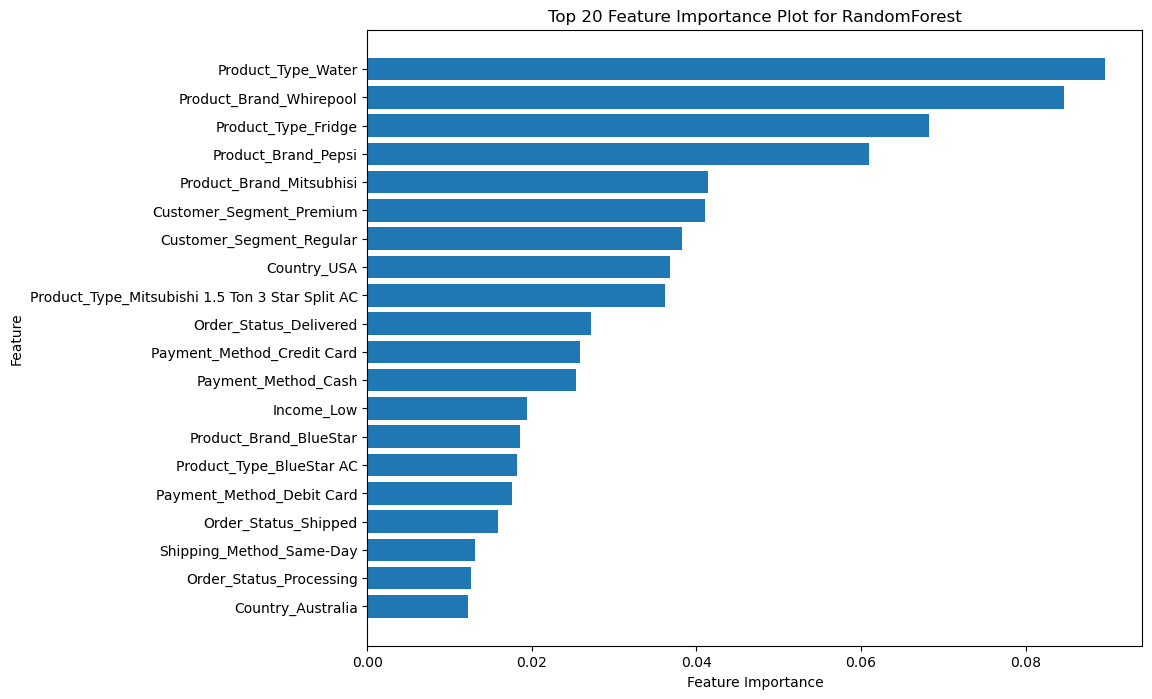

--- GradientBoosting ---
              precision    recall  f1-score   support

           1       0.23      0.14      0.18      8549
           2       0.30      0.22      0.25     12361
           3       0.46      0.22      0.30      9405
           4       0.33      0.66      0.44     19346
           5       0.30      0.05      0.08      9894

    accuracy                           0.32     59555
   macro avg       0.32      0.26      0.25     59555
weighted avg       0.32      0.32      0.28     59555



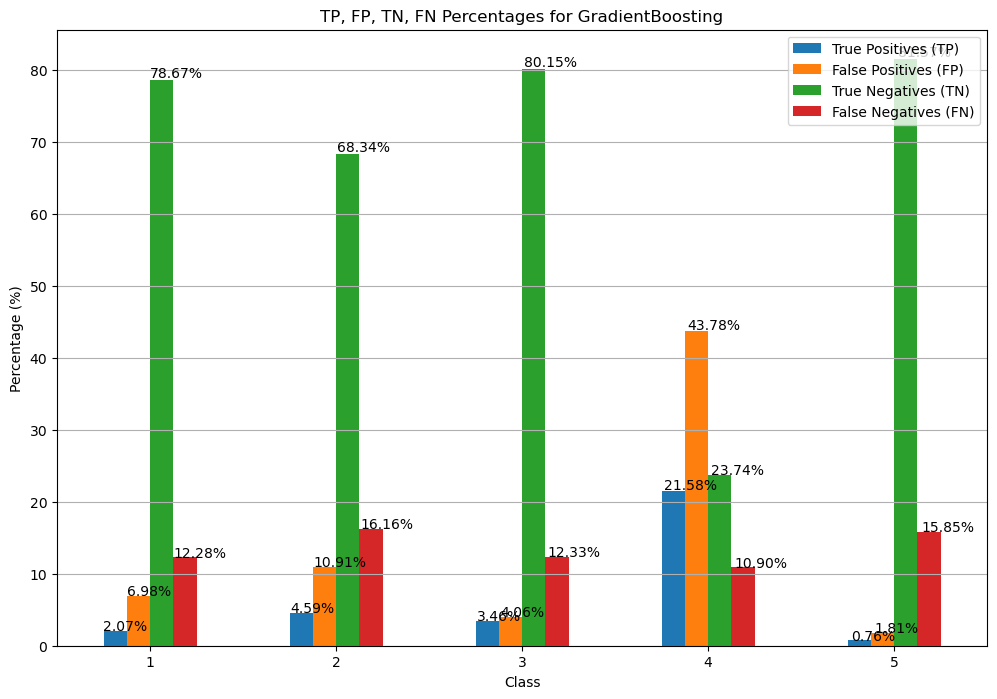

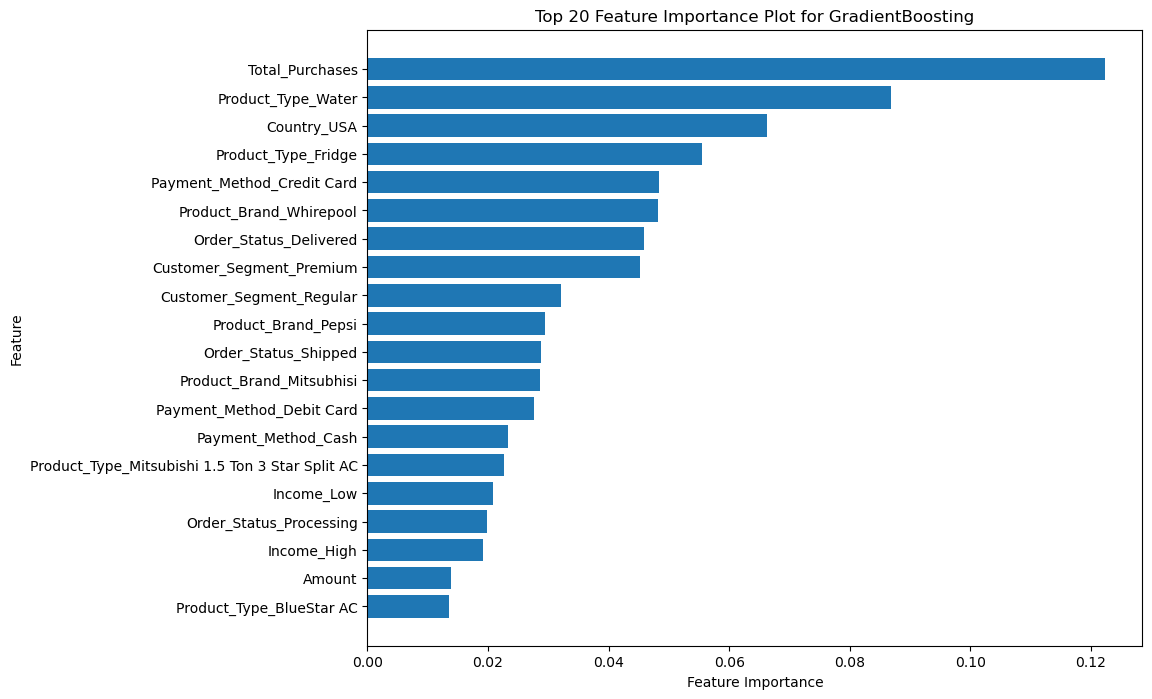

In [5]:
#MODEL TRAINING AND TESTING
# Visualize and train each model in the specified order
set_config(display='diagram')

for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', 'passthrough'),  # No need for additional preprocessing, since it's already done
        ('classifier', model)
    ])
    
    # Train and evaluate the model
    pipeline.fit(X_train_resampled, y_train_resampled)
    y_pred = pipeline.predict(X_test_transformed)
    
    # Print classification report and plot metrics
    print(f'--- {model_name} ---')
    print(classification_report(y_test, y_pred))
    
    # Create and calculate confusion matrix values
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_labels = sorted(y.unique())
    
    # Initialize lists to store the metrics for plotting
    tp_list, fp_list, tn_list, fn_list = [], [], [], []
    
    for i, class_label in enumerate(class_labels):
        TP = conf_matrix[i, i]
        FP = conf_matrix[:, i].sum() - TP
        FN = conf_matrix[i, :].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)
        
        # Calculate percentages
        total = TP + FP + FN + TN
        tp_list.append(TP / total * 100)
        fp_list.append(FP / total * 100)
        tn_list.append(TN / total * 100)
        fn_list.append(FN / total * 100)
    
    # Create a DataFrame for plotting
    metrics_df = pd.DataFrame({
        'Class': class_labels,
        'True Positives (TP)': tp_list,
        'False Positives (FP)': fp_list,
        'True Negatives (TN)': tn_list,
        'False Negatives (FN)': fn_list
    })
    
    # Plot the metrics as a grouped bar chart in percentages
    ax = metrics_df.set_index('Class').plot(kind='bar', figsize=(12, 8))
    plt.title(f'TP, FP, TN, FN Percentages for {model_name}')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Class')
    plt.xticks(rotation=0)
    plt.legend(loc='upper right')
    plt.grid(axis='y')

    # Annotate each bar with the percentage value
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() * 1.005, p.get_height() * 1.005))

    plt.show()

    # For feature importance plot only for RandomForest and GradientBoosting
    if model_name != 'LogisticRegression':
        importances = model.feature_importances_
        feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)  # Show only top 20 features
        
        plt.figure(figsize=(10, 8))
        plt.barh(importance_df['Feature'], importance_df['Importance'])
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.title(f'Top 20 Feature Importance Plot for {model_name}')
        plt.gca().invert_yaxis()
        plt.show()

## 2B. Prediction Using a Neural Network: BALANCED TRAINING SET

Epoch 1/20
9673/9673 - 24s - loss: 1.4960 - accuracy: 0.3145 - val_loss: 1.9443 - val_accuracy: 0.0607 - 24s/epoch - 2ms/step
Epoch 2/20
9673/9673 - 23s - loss: 1.4664 - accuracy: 0.3375 - val_loss: 1.9704 - val_accuracy: 0.0331 - 23s/epoch - 2ms/step
Epoch 3/20
9673/9673 - 24s - loss: 1.4473 - accuracy: 0.3534 - val_loss: 1.9709 - val_accuracy: 0.0223 - 24s/epoch - 2ms/step
Epoch 4/20
9673/9673 - 23s - loss: 1.4307 - accuracy: 0.3636 - val_loss: 2.0719 - val_accuracy: 0.0231 - 23s/epoch - 2ms/step
Epoch 5/20
9673/9673 - 23s - loss: 1.4169 - accuracy: 0.3721 - val_loss: 2.2333 - val_accuracy: 0.0071 - 23s/epoch - 2ms/step
Epoch 6/20
9673/9673 - 23s - loss: 1.4070 - accuracy: 0.3761 - val_loss: 2.2362 - val_accuracy: 0.0178 - 23s/epoch - 2ms/step
Epoch 7/20
9673/9673 - 22s - loss: 1.3982 - accuracy: 0.3806 - val_loss: 2.3388 - val_accuracy: 0.0352 - 22s/epoch - 2ms/step
Epoch 8/20
9673/9673 - 24s - loss: 1.3909 - accuracy: 0.3819 - val_loss: 2.5327 - val_accuracy: 0.0043 - 24s/epoch - 3

c:\Users\pocho\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pocho\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pocho\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

           1       0.20      0.23      0.21      8549
           2       0.30      0.20      0.24     12361
           3       0.46      0.01      0.01      9405
           4       0.35      0.73      0.47     19346
           5       0.00      0.00      0.00      9894

    accuracy                           0.31     59555
   macro avg       0.26      0.23      0.19     59555
weighted avg       0.28      0.31      0.24     59555



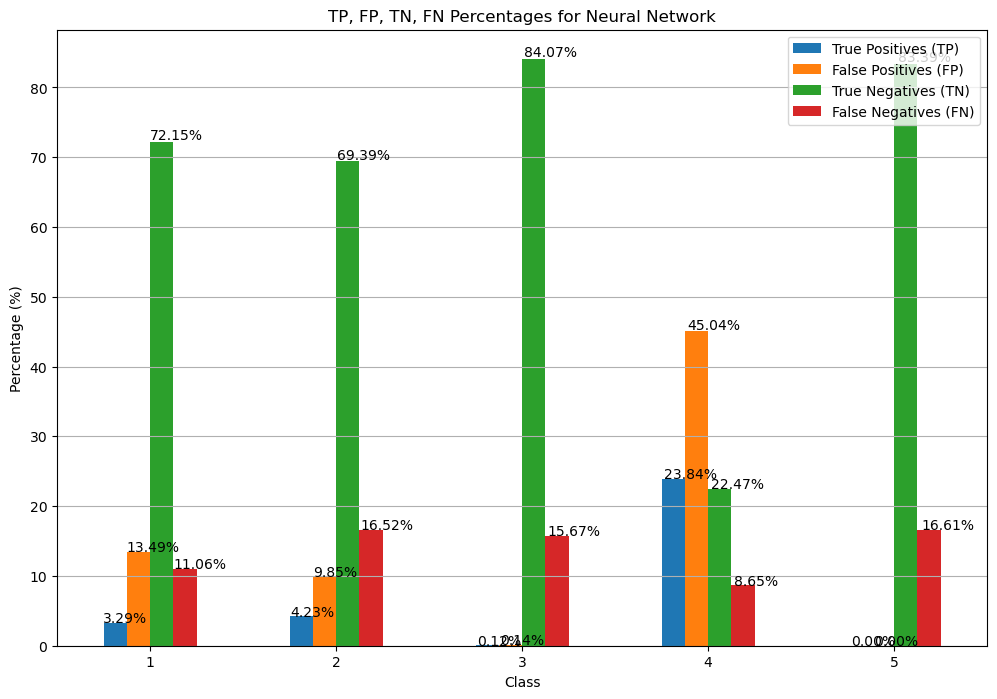

In [15]:
#NEURAL NETWORK PREDICTION
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from scipy.sparse import csr_matrix, csc_matrix  # Importing sparse matrix types

# Define preprocessing pipeline
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = ['Total_Purchases', 'Amount']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Preprocess the features
X_transformed = preprocessor.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# If X_train_resampled is sparse, convert to dense
if isinstance(X_train_resampled, (csr_matrix, csc_matrix)):
    X_train_resampled = X_train_resampled.toarray()
    X_test = X_test.toarray()

# Convert the transformed training data back to a DataFrame with correct feature names
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=preprocessor.get_feature_names_out())
X_test_df = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())

# One-hot encode the labels for the neural network
y_train_nn = to_categorical(y_train_resampled)
y_test_nn = to_categorical(y_test)

# Define the neural network model
model = Sequential()

# Input layer
model.add(Dense(units=64, activation='relu', input_shape=(X_train_resampled_df.shape[1],)))

# Hidden layers
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer with softmax activation for multi-class classification
model.add(Dense(units=y_train_nn.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_resampled_df, y_train_nn, epochs=20, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_df, y_test_nn, verbose=2)

print(f'\nTest Accuracy: {test_accuracy:.2f}')

# Predict on the test set
y_pred_nn = model.predict(X_test_df)
y_pred_classes_nn = y_pred_nn.argmax(axis=-1)  # Convert predictions to class labels

# Classification report
print(classification_report(y_test, y_pred_classes_nn))

# Confusion matrix
conf_matrix_nn = confusion_matrix(y_test, y_pred_classes_nn)

# Plot confusion matrix and metrics
class_labels = sorted(y.unique())

# Initialize lists to store the metrics for plotting
tp_list, fp_list, tn_list, fn_list = [], [], [], []

for i, class_label in enumerate(class_labels):
    TP = conf_matrix_nn[i, i]
    FP = conf_matrix_nn[:, i].sum() - TP
    FN = conf_matrix_nn[i, :].sum() - TP
    TN = conf_matrix_nn.sum() - (TP + FP + FN)
    
    # Calculate percentages
    total = TP + FP + FN + TN
    tp_list.append(TP / total * 100)
    fp_list.append(FP / total * 100)
    tn_list.append(TN / total * 100)
    fn_list.append(FN / total * 100)

# Create a DataFrame for plotting
metrics_df_nn = pd.DataFrame({
    'Class': class_labels,
    'True Positives (TP)': tp_list,
    'False Positives (FP)': fp_list,
    'True Negatives (TN)': tn_list,
    'False Negatives (FN)': fn_list
})

# Plot the metrics as a grouped bar chart in percentages
ax = metrics_df_nn.set_index('Class').plot(kind='bar', figsize=(12, 8))
plt.title(f'TP, FP, TN, FN Percentages for Neural Network')
plt.ylabel('Percentage (%)')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.grid(axis='y')

# Annotate each bar with the percentage value
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()
